<a href="https://colab.research.google.com/github/valmirf/processamento_imagens/blob/master/Processamento/Aula_05_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opencv - Aula 5

Imports necessários

In [7]:
!git clone https://github.com/valmirf/processamento_imagens.git

fatal: destination path 'processamento_imagens' already exists and is not an empty directory.


In [0]:
#!pip install opencv-python
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

## 1. Detecção de Bordas

### 1.2 Filtro com Máscaras de Derivadas


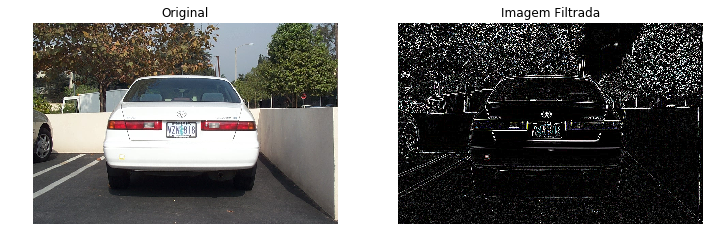

In [9]:
img = cv2.imread('processamento_imagens/imagens/image_0089.jpg')
#print(logo)
kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])  #máscara filtro de pontos

dst_img = cv2.filter2D(img,-1,kernel) #filtragem


fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(dst_img, cmap='gray')
ax[1].set_title('Imagem Filtrada')
ax[1].set_axis_off()

### 1.2 Laplaciano da Gaussiana (Log)


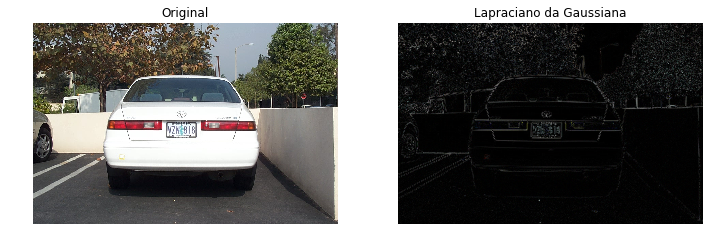

In [10]:
blurGaussian = cv2.GaussianBlur(img,(3,3),0)  #Filtro da Gaussiana

laplacian = cv2.Laplacian(blurGaussian,cv2.CV_64F)  # Filtro Laplaciano
# converting back to uint8
abs_dst = cv2.convertScaleAbs(laplacian)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(abs_dst, cmap='gray')
ax[1].set_title('Lapraciano da Gaussiana')
ax[1].set_axis_off()

### 1.3 Canny

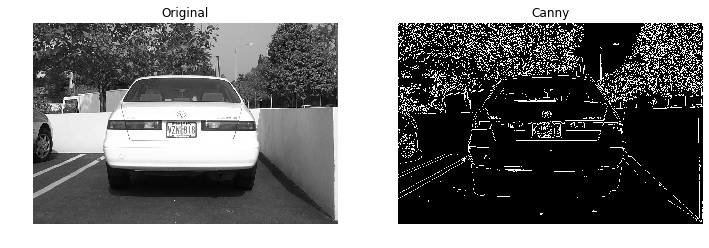

In [11]:
img = cv2.imread('processamento_imagens/imagens/image_0089.jpg',0)
edges = cv2.Canny(img,100,200)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Canny')
ax[1].set_axis_off()

#plotar
#plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
#plt.axis("off")
#plt.imshow(edges, cmap='gray')

### 1.4 Transformada de hough

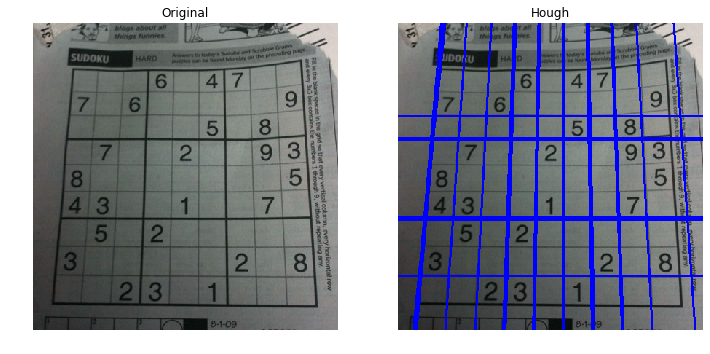

In [12]:
img = cv2.imread('processamento_imagens/imagens/dave.png')
imgOut = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,100,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for i in range(len(lines)): 
    for rho,theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(imgOut,(x1,y1),(x2,y2),(0,0,255),2)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(imgOut, cmap='gray')
ax[1].set_title('Hough')
ax[1].set_axis_off()

## 2. Segmentação

### 2.4 Componentes Conexos

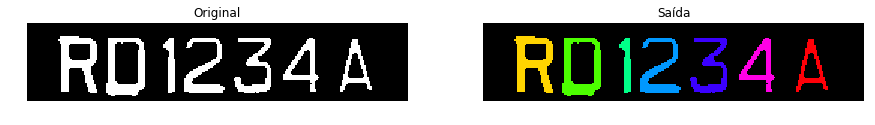

In [13]:
img4 = cv2.imread('processamento_imagens/imagens/letras.png', 0)
img4 = cv2.threshold(img4, 127, 255, cv2.THRESH_BINARY)[1]  # imagem binária
#img4 = cv2.bitwise_not(img4)  # imagem negativada, objeto de interesse precisa ser branco
ret, labels = cv2.connectedComponents(img4)

# Associa os rótulos a cores 
label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# HSV para BGR
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# Associa o fundo a cor preta
labeled_img[label_hue==0] = 0

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax = axes.ravel()

ax[0].imshow(img4, cmap='gray')
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Saída')
ax[1].set_axis_off()


### 2.3 Watershed

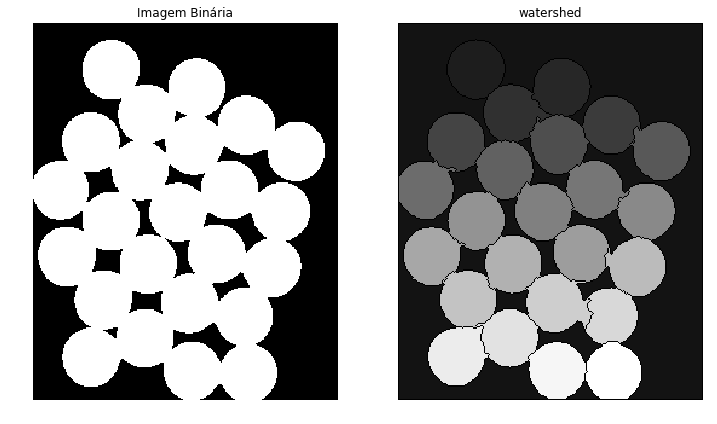

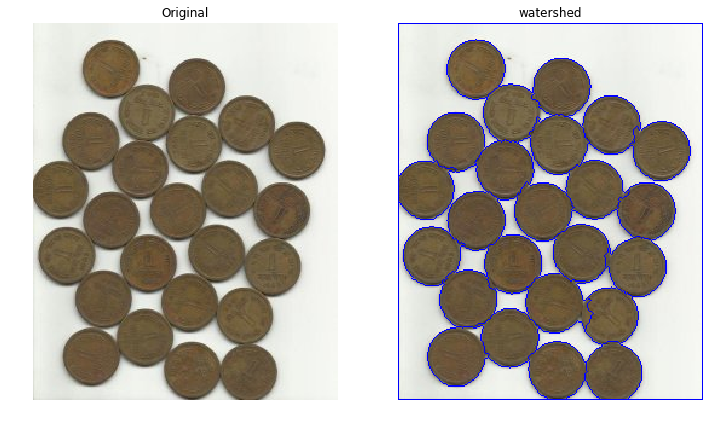

In [14]:
img3 = cv2.imread('processamento_imagens/imagens/water_coins.jpg')
img3c = img3.copy()
gray = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# remove ruídos
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# Fundo da imagem
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Objetos da imagem
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Encontrando regiões desconhecidas
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Rotulando a imagem
ret, markers = cv2.connectedComponents(sure_fg)

# Marca os objetos
markers = markers+1

# Regiões desconhecidas serão 0
markers[unknown==255] = 0

markers = cv2.watershed(img3,markers)
img3[markers == -1] = [255,0,0]

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(opening, cmap='gray')
ax[0].set_title('Imagem Binária')
ax[0].set_axis_off()

ax[1].imshow(markers, cmap='gray')
ax[1].set_title('watershed')
ax[1].set_axis_off()

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(cv2.cvtColor(img3c, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax[1].set_title('watershed')
ax[1].set_axis_off()

### 2.1 Limiarização

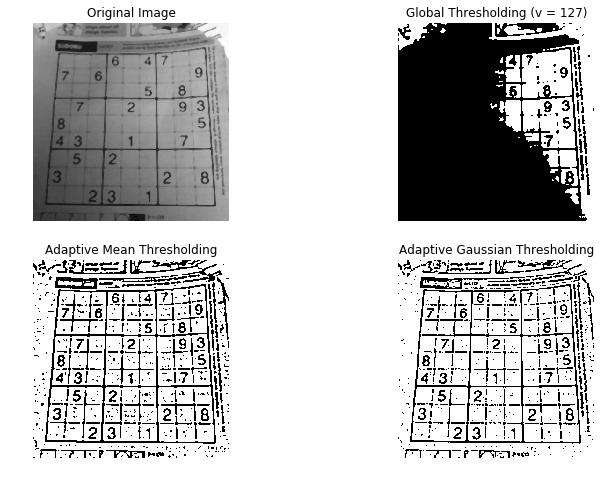

In [15]:
img = cv2.imread('processamento_imagens/imagens/dave.png',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
#th3 = cv2.threshold(img,125,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #OTSU

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax = axes.ravel()
for i in range(4):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].set_axis_off()

### 2.2 K-Means Clustering

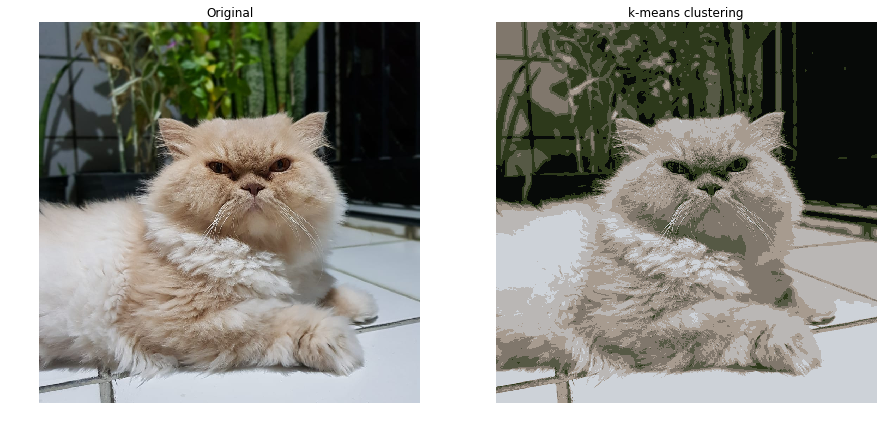

In [16]:
img2 = cv2.imread('processamento_imagens/imagens/pudimcat.jpg')
Z = img2.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 7
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img2.shape))

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax = axes.ravel()

ax[0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))
ax[1].set_title('k-means clustering')
ax[1].set_axis_off()

### 2.3 MeanShift

#### Parâmetros:	
    src – Imagem original de 8-bits, 3-canais
    dst – A imagem de destino com o mesmo formato e o mesmo           tamanho da imagem original.
    sp –  O raio da janela espacial.
    sr –  O raio da janela colorida.
    maxLevel – Nível máximo para a segmentação.
    termcrit – Critério de Parada

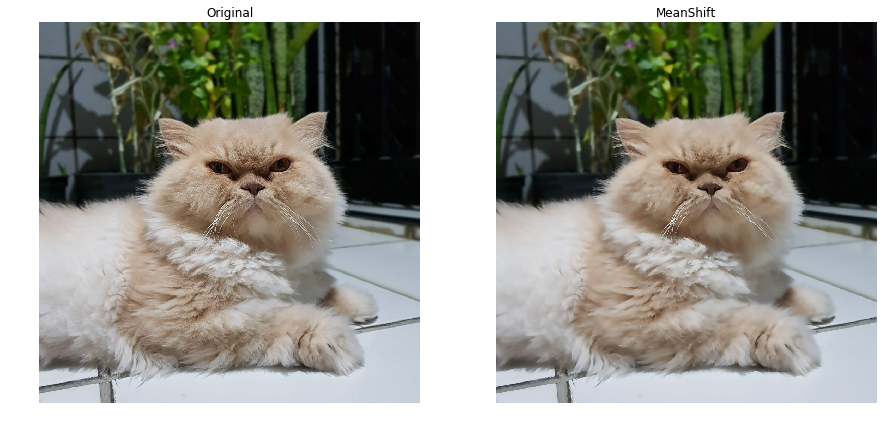

In [17]:
meanshift = cv2.pyrMeanShiftFiltering(img2, sp=2, sr=32, maxLevel=1, 
                                      termcrit=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 5, 1))
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax = axes.ravel()

ax[0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))#convertendo para RGB antes de plotar
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(meanshift, cv2.COLOR_BGR2RGB))#convertendo para RGB antes de plotar
ax[1].set_title('MeanShift')
ax[1].set_axis_off()

# Exercícios

## 1. Encontre a borda que divide o horizonte da imagem abaixo 

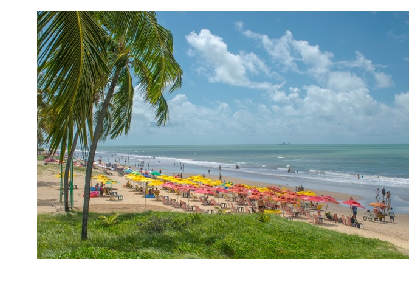

In [18]:
img1 = cv2.imread('processamento_imagens/imagens/boa_viagem.jpg')

plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.axis("off")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


## 2. Encontre a melhor estratégia para contar o número de mangas na imagem abaixo.

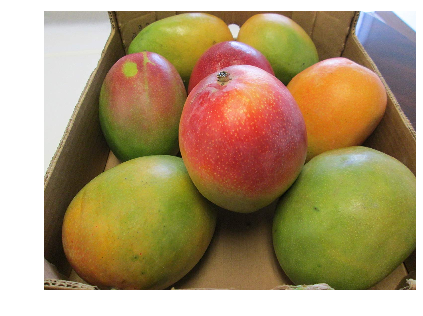

In [19]:
img2 = cv2.imread('processamento_imagens/imagens/mangas.jpg')

plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.axis("off")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
